Size 5, Freq 2:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\y-osw\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
c:\Users\y-osw\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Size 5, Freq 2:  20%|██        | 1/5 [00:07<00:29,  7.30s/it]c:\Users\y-osw\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Size 5, Freq 2:  40%|████      | 2/5 [00:14<00:21,  7.19s/it]c:\Users\y-osw\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Size 5, Freq 2:  60%|██████    | 3/5 [00

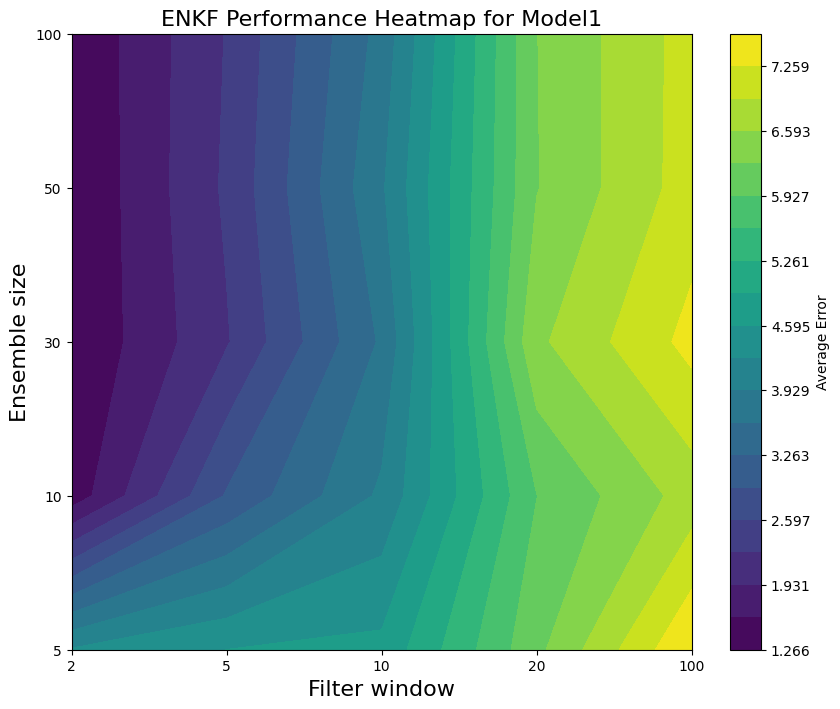

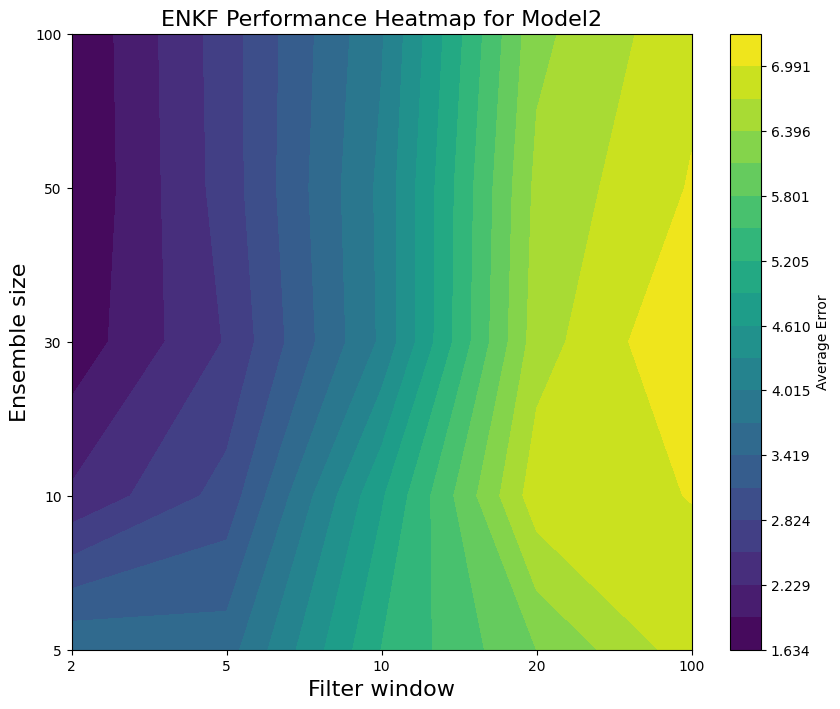

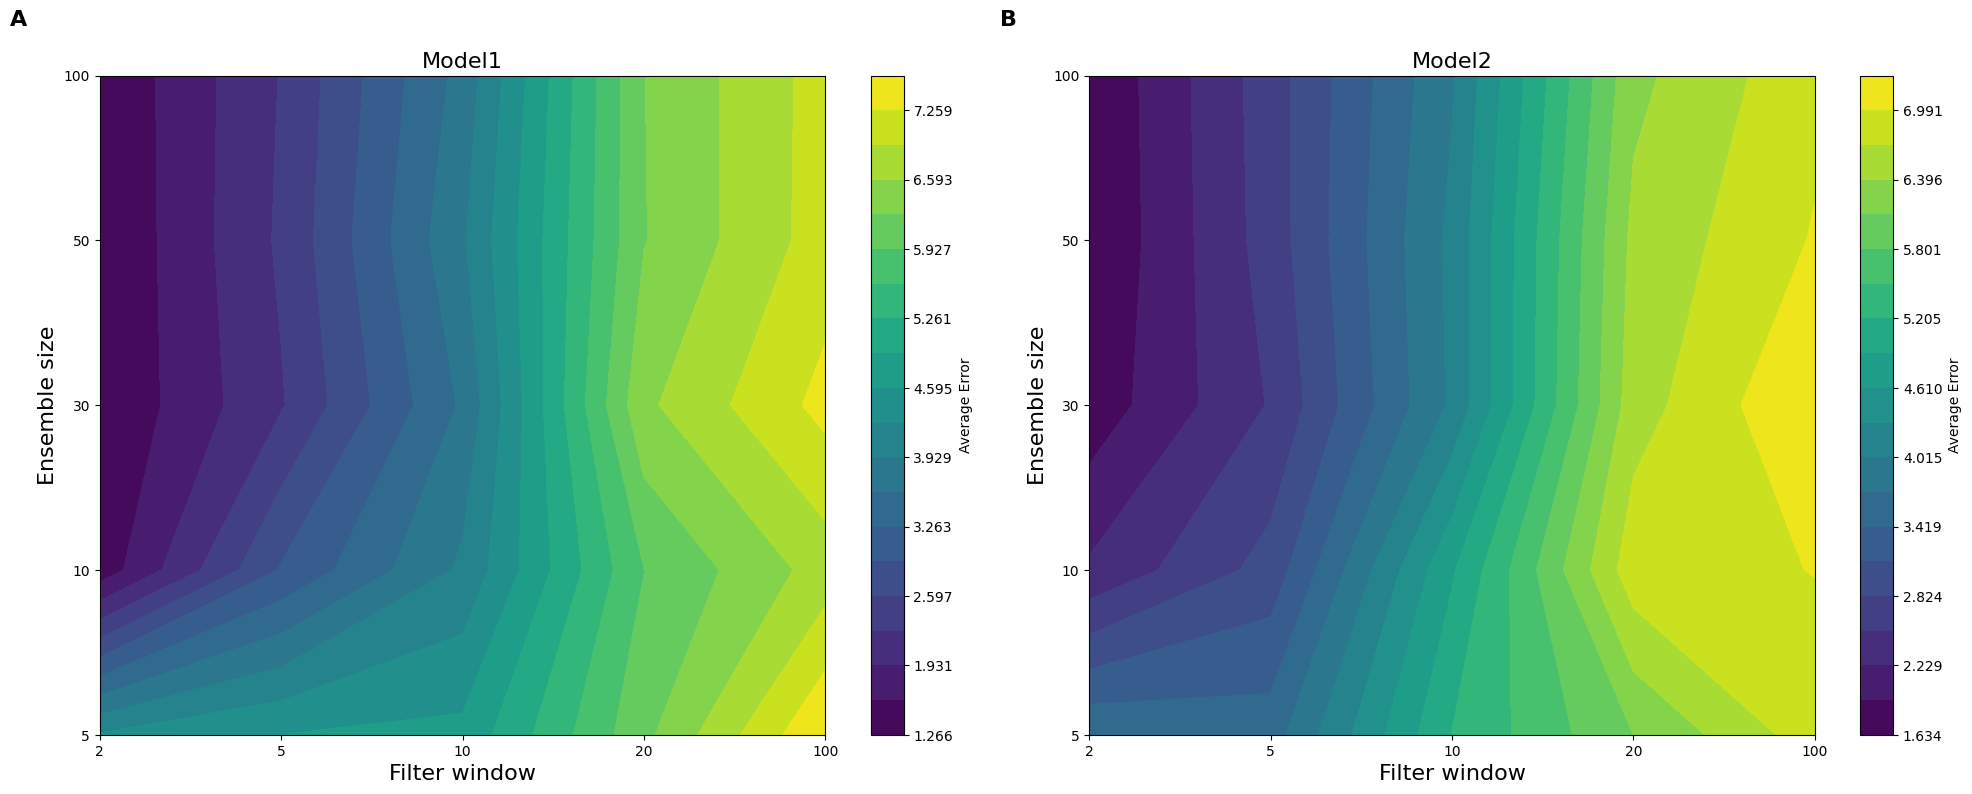

In [4]:

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from model1_class import Model1
from model2_class import Model2
from run_enkf import prepare_enkf, run_enkf

class Enkf_experiment4:
    def __init__(self, num_agents, macro_state_dim, repetitions, ensemble_sizes, filter_frequencies, model_params1, model_params2):
        assert macro_state_dim == 3 or macro_state_dim == 4, "Incorrect dimensions for macro state."
        self.num_agents = num_agents
        self.macro_state_dim = macro_state_dim
        self.repetitions = repetitions
        self.ensemble_sizes = ensemble_sizes
        self.filter_frequencies = filter_frequencies
        self.model_params1 = model_params1
        self.model_params2 = model_params2
        self.results_model1 = np.zeros((len(ensemble_sizes), len(filter_frequencies)))
        self.results_model2 = np.zeros((len(ensemble_sizes), len(filter_frequencies)))

    def run_experiment(self):
        time_horizon = 12*2  # or any other appropriate value
        for i, size in enumerate(self.ensemble_sizes):
            for j, freq in enumerate(self.filter_frequencies):
                error_sum_enkf1 = 0
                error_sum_enkf2 = 0
                for _ in tqdm(range(self.repetitions), desc=f"Size {size}, Freq {freq}"):
                    
                    enkf1 = prepare_enkf(Model1,
                                              model_params= model_params1,
                                              ensemble_size = size,
                                              macro_state_dim = self.macro_state_dim,
                                              filter_freq = freq,
                                              uncertainty_obs = 0.05)
                    enkf2 = prepare_enkf(Model2, model_params= model_params2,
                                              ensemble_size = size,
                                              macro_state_dim = self.macro_state_dim,
                                              filter_freq = freq,
                                              uncertainty_obs = 0.05)
                    
                    run_enkf(enkf1, time_horizon, freq)
                    run_enkf(enkf2, time_horizon, freq)
                    error_sum_enkf1 += enkf1.integral_error()
                    error_sum_enkf2 += enkf2.integral_error()
                self.results_model1[i, j] = error_sum_enkf1 / self.repetitions
                self.results_model2[i, j] = error_sum_enkf2 / self.repetitions


    def plot_heatmap(self, results, model_name, ax=None, save_fig=False, fig_name='heatmap.png'):
        # Define the levels of contours
        levels = np.linspace(np.min(results), np.max(results), num=20)
    
        # If an Axes object isn't provided, create a new figure and Axes
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
    
        # Create the contour plot on the provided Axes
        contour = ax.contourf(results, levels=levels, cmap='viridis', extend='neither')
        cbar = plt.colorbar(contour, ax=ax, label='Average Error', extend='neither')
        
        # Set the labels for ticks if needed
        ax.set_xticks(ticks=np.arange(len(self.filter_frequencies)), labels=self.filter_frequencies)
        ax.set_yticks(ticks=np.arange(len(self.ensemble_sizes)), labels=self.ensemble_sizes)
    
        # Set the labels and title
        ax.set_xlabel('Filter window', fontsize = 16)
        ax.set_ylabel('Ensemble size', fontsize = 16)
        ax.set_title(f'ENKF Performance Heatmap for {model_name}', fontsize = 16)
        
        # Save the figure if requested and if no specific Axes is provided
        if save_fig and ax is None:
            plt.savefig(f"{model_name}_{fig_name}", dpi=300)
    
        # Return the Axes object
        return ax

# Usage
model_params1 = {"population_size": 100,
 "growth_rate": 0.025,
 "b_begin": 1.3,
 "distribution": "Pareto_lognormal",
 "start_year": 1990 }

model_params2 = {"population_size": 100, 
                "concavity": 1,
                "growth_rate": 0.025, 
                "start_year": 1990,
                "adaptive_sensitivity": 0.02}



model_params1 = {"population_size": 100,
 "growth_rate": 0.025,
 "b_begin": 1.3,
 "distribution": "Pareto_lognormal",
 "start_year": 1990,
 "uncertainty_para": 0}

model_params2 = {"population_size": 100, 
                "concavity": 1,
                "growth_rate": 0.025, 
                "start_year": 1990,
                "adaptive_sensitivity": 0.02,
                "uncertainty_para": 0}

experiment = Enkf_experiment4(num_agents=100, macro_state_dim=4, repetitions=5,
                              ensemble_sizes= [5, 10, 30, 50, 100], 
                              filter_frequencies = [2, 5, 10, 20, 100],
                              model_params1=model_params1, model_params2=model_params2)

experiment.run_experiment()
experiment.plot_heatmap(experiment.results_model1, "Model1", save_fig=True)
experiment.plot_heatmap(experiment.results_model2, "Model2", save_fig=True)


# Create a figure for the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot heatmap for Model 1 in the first subplot (ax1)
experiment.plot_heatmap(experiment.results_model1, "Model1", ax=ax1, save_fig=False)
ax1.set_title('Model1', fontsize = 16)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot heatmap for Model 2 in the second subplot (ax2)
experiment.plot_heatmap(experiment.results_model2, "Model2", ax=ax2, save_fig=False)
ax2.set_title('Model2', fontsize = 16)
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the entire figure
plt.savefig('fig7.png', dpi=300)

# Show the plot
plt.show()
